# LSTM
(Time series)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks

In [3]:
dataset = pd.read_csv('stock.csv')

In [4]:
dataset


,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-09-28,234.05,235.95,230.20,233.50,233.75,3069914,7162.35
1,2018-09-27,234.55,236.80,231.10,233.80,233.25,5082859,11859.95
2,2018-09-26,240.00,240.00,232.50,235.00,234.25,2240909,5248.60
3,2018-09-25,233.30,236.75,232.00,236.25,236.10,2349368,5503.90
4,2018-09-24,233.55,239.20,230.75,234.00,233.30,3423509,7999.55
...,...,...,...,...,...,...,...,...
2030,2010-07-27,117.60,119.50,112.00,118.80,118.65,586100,694.98
2031,2010-07-26,120.10,121.00,117.10,117.10,117.60,658440,780.01
2032,2010-07-23,121.80,121.95,120.25,120.35,120.65,281312,340.31
2033,2010-07-22,120.30,122.00,120.25,120.75,120.90,293312,355.17


In [5]:

series = dataset['Close']
series.index=dataset['Date']
series

Date
2018-09-28    233.75
2018-09-27    233.25
2018-09-26    234.25
2018-09-25    236.10
2018-09-24    233.30
               ...  
2010-07-27    118.65
2010-07-26    117.60
2010-07-23    120.65
2010-07-22    120.90
2010-07-21    121.55
Name: Close, Length: 2035, dtype: float64

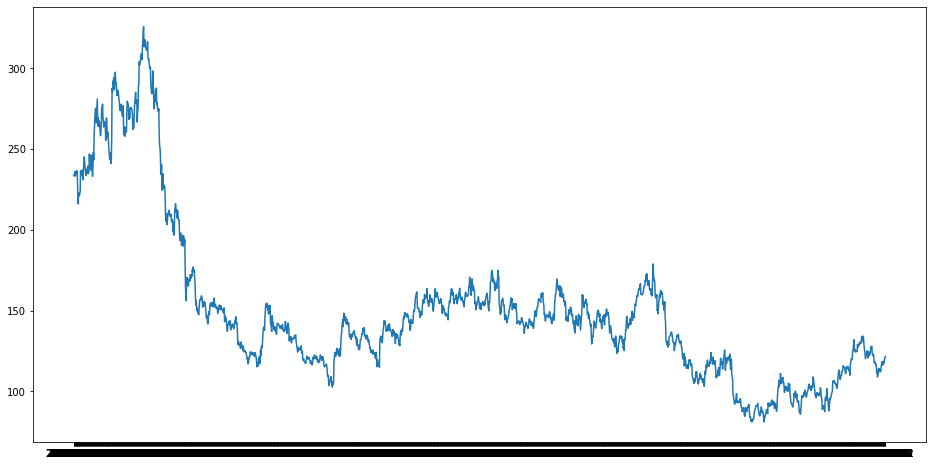

In [6]:
plt.figure(figsize=(16,8))
plt.plot(series)


In [7]:
# spliting the training set and validation data
pt= int(0.75* len(series))
x_train= series[:pt]
x_val = series [pt:]


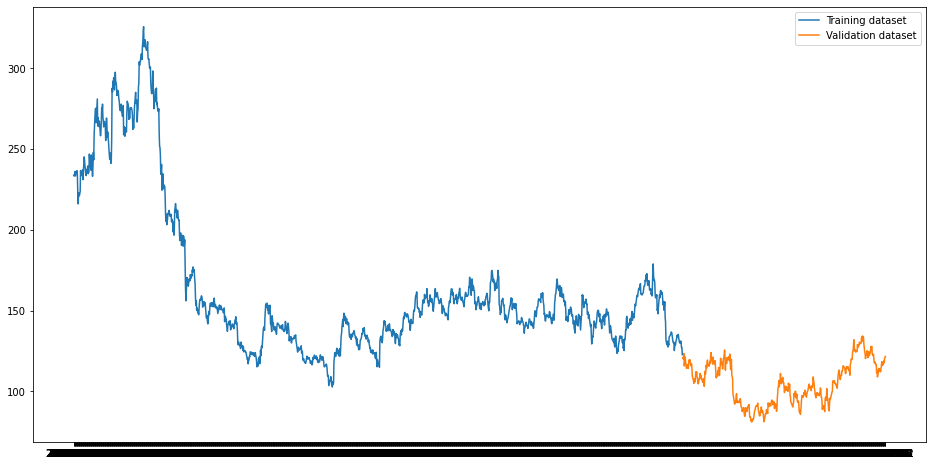

In [8]:
#plotting again
plt.figure(figsize=(16,8))
plt.plot(x_train, label="Training dataset")
plt.plot(x_val, label="Validation dataset")
plt.legend()

In [119]:
# now we are gonna create windows 
def window_dataset(series, window_size):
    series=tf.expand_dims(series, axis=-1)
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset= dataset.window(window_size+1, shift=window_size, drop_remainder=True)
    dataset= dataset.flat_map(lambda window: window.batch(window_size+1))    # machine learning model needs the tensors , it returns the tensor
    dataset= dataset.map(lambda window: (window[:-1], window[1:]))

    dataset= dataset.batch(1).prefetch(1)    #prefetch method is for performance that it will ensure that while one batch is being 
    #trained , the other batch is being prepared
    return dataset

In [120]:
window_size= 30
train_set=window_dataset(x_train, window_size)
val_set=window_dataset(x_val, window_size)

In [121]:
for x,y in train_set:
  print("feature =", x.numpy())
  print("target =", y.numpy())

  break

feature = [[[233.75]
  [233.25]
  [234.25]
  [236.1 ]
  [233.3 ]
  [234.6 ]
  [234.9 ]
  [235.05]
  [236.6 ]
  [233.95]
  [222.65]
  [216.  ]
  [222.  ]
  [222.95]
  [221.05]
  [222.4 ]
  [223.7 ]
  [236.7 ]
  [234.3 ]
  [236.  ]
  [234.55]
  [233.35]
  [237.05]
  [231.  ]
  [235.45]
  [240.55]
  [245.15]
  [243.  ]
  [239.35]
  [237.55]]]
target = [[[233.25]
  [234.25]
  [236.1 ]
  [233.3 ]
  [234.6 ]
  [234.9 ]
  [235.05]
  [236.6 ]
  [233.95]
  [222.65]
  [216.  ]
  [222.  ]
  [222.95]
  [221.05]
  [222.4 ]
  [223.7 ]
  [236.7 ]
  [234.3 ]
  [236.  ]
  [234.55]
  [233.35]
  [237.05]
  [231.  ]
  [235.45]
  [240.55]
  [245.15]
  [243.  ]
  [239.35]
  [237.55]
  [234.55]]]


In [209]:
# model 
lstm= models.Sequential([
                        #layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),input_shape=[None]),
                        layers.Conv1D(filters=30, kernel_size=3, strides=1, padding="causal", activation="relu", input_shape=[None,1] ),
                        layers.LSTM(100, return_sequences=True),
                        layers.Dense(1),
                        layers.Lambda(lambda x: x*200.0)
])

In [210]:
lr_schedule = callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch/20)
)
#compilation of model 
lstm.compile(loss=keras.losses.Huber(), optimizer=optimizers.SGD(learning_rate=1e-6,momentum =0.9), metrics=["mae"])

In [211]:

csv_log = callbacks.CSVLogger("training.csv", append=False, separator=',')
earlystopping=callbacks.EarlyStopping(patience =10)
history= lstm.fit(train_set, epochs=100, validation_data=val_set, callbacks=[earlystopping, csv_log, lr_schedule])

Epoch 1/100
50/50 [==============================] - 3s 16ms/step - loss: 71.3807 - mae: 71.8768 - val_loss: 40.9214 - val_mae: 41.4210 - lr: 1.0000e-07
Epoch 2/100
50/50 [==============================] - 0s 7ms/step - loss: 35.1681 - mae: 35.6631 - val_loss: 31.0673 - val_mae: 31.5665 - lr: 1.1220e-07
Epoch 3/100
50/50 [==============================] - 0s 7ms/step - loss: 27.9145 - mae: 28.4080 - val_loss: 20.8934 - val_mae: 21.3927 - lr: 1.2589e-07
Epoch 4/100
50/50 [==============================] - 0s 7ms/step - loss: 24.3317 - mae: 24.8244 - val_loss: 12.5228 - val_mae: 13.0211 - lr: 1.4125e-07
Epoch 5/100
50/50 [==============================] - 0s 7ms/step - loss: 20.6675 - mae: 21.1575 - val_loss: 8.9515 - val_mae: 9.4425 - lr: 1.5849e-07
Epoch 6/100
50/50 [==============================] - 0s 7ms/step - loss: 21.5692 - mae: 22.0632 - val_loss: 3.9627 - val_mae: 4.4323 - lr: 1.7783e-07
Epoch 7/100
50/50 [==============================] - 0s 8ms/step - loss: 17.9677 - mae: 18.

In [212]:
lstm.save('stock.h5')

In [213]:
lstm= models.load_model('stock.h5')

In [214]:
def model_forecast(model,series, window_size):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset= dataset.window(window_size, shift=1, drop_remainder=True)
    dataset= dataset.flat_map(lambda window: window.batch(window_size+1))    # machine learning model needs the tensors , it returns the tensor
    dataset= dataset.batch(32).prefetch(1)    #prefetch method is for performance that it will ensure that while one batch is being 
    #trained , the other batch is being prepared
    return model.predict(dataset)



In [215]:
lstm_forecast= lstm.predict(series[np.newaxis, : , np.newaxis])
lstm_forecast= lstm_forecast[0,pt-1:-1,0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  """Entry point for launching an IPython kernel.


In [216]:
lstm_forecast

array([130.63934 , 128.95148 , 127.96411 , 127.96123 , 129.04568 ,
       125.56889 , 126.64892 , 126.9912  , 127.06082 , 125.78367 ,
       124.14582 , 123.49856 , 123.80386 , 124.39656 , 124.41796 ,
       123.71913 , 125.201324, 125.92301 , 126.71496 , 127.28698 ,
       126.47453 , 125.331154, 124.77405 , 125.11343 , 124.24376 ,
       120.74396 , 119.2975  , 118.39919 , 117.37673 , 116.451584,
       116.71231 , 117.66007 , 116.94768 , 118.748   , 120.1774  ,
       120.53453 , 121.78271 , 119.99085 , 119.16404 , 117.0763  ,
       116.30449 , 116.61286 , 117.60275 , 117.94152 , 119.64137 ,
       120.3     , 119.13031 , 120.01284 , 118.59157 , 118.24479 ,
       117.80907 , 116.90773 , 117.886604, 117.99885 , 116.59951 ,
       115.32105 , 117.94039 , 119.12042 , 120.31574 , 122.186295,
       123.37339 , 123.40741 , 125.32936 , 125.97137 , 125.73039 ,
       125.4637  , 124.62518 , 124.31181 , 124.72768 , 125.61052 ,
       125.56137 , 127.66325 , 128.70007 , 127.82943 , 127.394

In [217]:
lstm_forecast=pd.Series(lstm_forecast, index=x_val.index)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

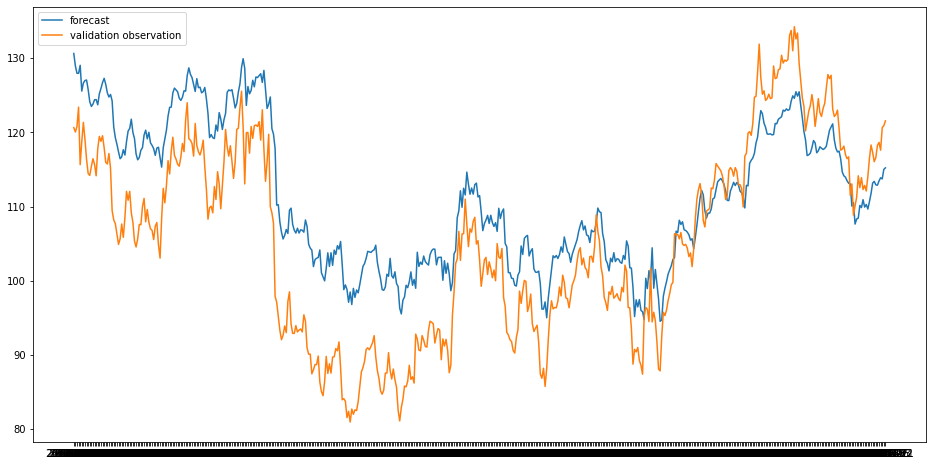

In [218]:
#plotting
plt.figure(figsize=(16,8))
plt.plot(lstm_forecast, label="forecast")
plt.plot(x_val, label ="validation observation")
plt.legend()
plt

In [219]:
from tensorflow.keras import metrics

metrics.mean_absolute_error(x_val, lstm_forecast).numpy()

7.709018

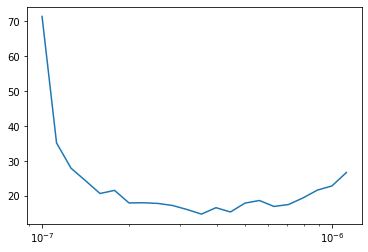

In [220]:
plt.semilogx(history.history["lr"], history.history["loss"])

# Wavenets architecture Forecasting using CNN

---



In [248]:
dilations = [1,3,6,12]
cnn = models.Sequential()
for dilation in dilations:
  cnn.add(
      layers.Conv1D(filters=32, strides=1, kernel_size=2, dilation_rate=dilation, padding="causal", activation="relu")
  )
cnn.add(
    layers.Conv1D(filters=1, kernel_size=1)
)

In [249]:
cnn.compile(loss=keras.losses.Huber(), optimizer=optimizers.SGD(learning_rate=1e-6,momentum =0.9), metrics=["mae"])

In [255]:
cnn_history=cnn.fit(train_set, epochs=100, callbacks=[lr_schedule, earlystopping, csv_log], validation_data=val_set)

Epoch 1/100
50/50 [==============================] - 1s 11ms/step - loss: 59.6510 - mae: 60.1510 - val_loss: 46.4678 - val_mae: 46.9678 - lr: 1.0000e-07
Epoch 2/100
50/50 [==============================] - 1s 11ms/step - loss: 64.1128 - mae: 64.6127 - val_loss: 34.1553 - val_mae: 34.6553 - lr: 1.1220e-07
Epoch 3/100
50/50 [==============================] - 0s 8ms/step - loss: 44.6317 - mae: 45.1317 - val_loss: 21.8141 - val_mae: 22.3141 - lr: 1.2589e-07
Epoch 4/100
50/50 [==============================] - 0s 6ms/step - loss: 25.5765 - mae: 26.0765 - val_loss: 9.8841 - val_mae: 10.3841 - lr: 1.4125e-07
Epoch 5/100
50/50 [==============================] - 0s 6ms/step - loss: 8.2440 - mae: 8.7281 - val_loss: 2.0062 - val_mae: 2.4620 - lr: 1.5849e-07
Epoch 6/100
50/50 [==============================] - 0s 6ms/step - loss: 3.1217 - mae: 3.5828 - val_loss: 1.9248 - val_mae: 2.3765 - lr: 1.7783e-07
Epoch 7/100
50/50 [==============================] - 0s 6ms/step - loss: 2.9645 - mae: 3.4226 -

In [256]:
cnn_forecast= cnn.predict(series[np.newaxis, : , np.newaxis])
cnn_forecast= cnn_forecast[0,pt-1:-1,0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  """Entry point for launching an IPython kernel.


In [257]:
cnn_forecast=pd.Series(cnn_forecast, index=x_val.index)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

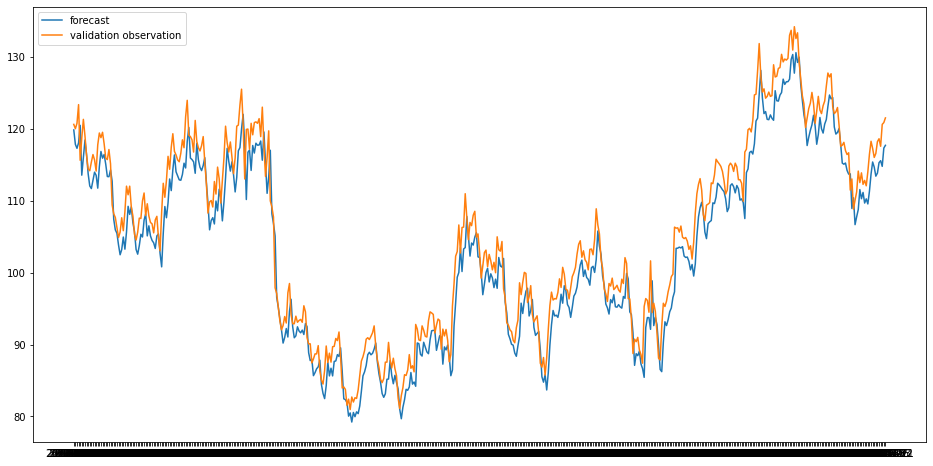

In [258]:
#plotting
plt.figure(figsize=(16,8))
plt.plot(cnn_forecast, label="forecast")
plt.plot(x_val, label ="validation observation")
plt.legend()
plt

In [259]:
metrics.mean_absolute_error(x_val, cnn_forecast).numpy()

2.880767

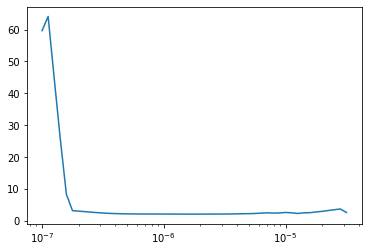

In [260]:
plt.semilogx(cnn_history.history["lr"], cnn_history.history["loss"])